In [74]:
import random
import numpy as np
import pandas as pd
import json
import cv2
import os
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torchvision
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
import torch
from PIL import Image
from imutils.video import FileVideoStream
from pipeline.metrics import accuracy_b, log_loss
from pipeline.model_methods import validate_img, train_img, validate_vid, train_vid
from pipeline.data_loaders import load_img_dataset, load_img_val_dataset
from pipeline.image_extracting import extract_faces, FastMTCNN

from pipeline.metrics import accuracy_sigmoid, accuracy_sigmoid_mean, log_loss_sigmoid, log_loss_b, accuracy_b_mean
from pipeline.model_methods import validate_vid_bf, train_vid_bf
from pipeline.image_extracting import crop_faces, FastMTCNN, InceptionResnetV1, extract_faces_dlib, MTCNN
from pipeline.blazeface import BlazeFace
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, ImageCompression, Resize, RandomScale, RandomFog, RandomShadow, Downscale, JpegCompression, CenterCrop,
    RandomGamma, RandomContrast, Cutout, RandomCrop, Normalize, Cutout, RandomFog,Posterize,GaussianBlur
)
from albumentations.pytorch import ToTensor


random.seed(0)
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

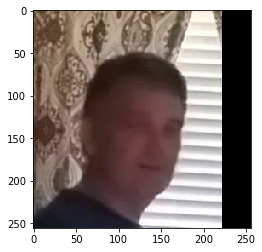

In [83]:
image = cv2.imread(r'C:\Users\user\Desktop\Projects\dfdc-kaggle-solution\data\train\fake\gigkljbtnw.0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

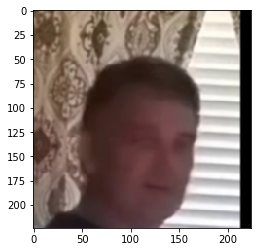

In [100]:
aug = RandomCrop(224,224)(image=image)['image']
#aug = JpegCompression(quality_lower=15, quality_upper=50, p=1)(image=aug)['image']
#aug = Downscale(scale_min=0.5, scale_max=0.9, p=1)(image=aug)['image']
aug = GaussianBlur(blur_limit=20,p=1)(image=aug)['image']
plt.imshow(aug)
plt.show()

In [2]:
facedet = BlazeFace().to(device)
facedet.load_weights("pipeline/blazeface.pth")
facedet.load_anchors("pipeline/anchors.npy")
_ = facedet.train(False)

from pipeline.helpers.read_video_1 import VideoReader
from pipeline.helpers.face_extract_1 import FaceExtractor

frames_per_video = 1

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [3]:
y_train = pd.read_csv(r'data\metadata.csv')

In [4]:
js = {}
for i in range(40, 50):
    with open(r'D:\Machine Learning\deepfake-detection\data\train_sets\dfdc_train_part_' + str(i) + '\metadata.json', 'r') as r:
        js.update(json.loads(r.read()))

In [13]:
path_val = r'data\img_val\fake'
path_fake = r'data\train\fake'
path_real = r'data\train\real'
path_fake2 = r'data\train2\fake'

val = [i for i in os.listdir(path_val)] 
fake = [i for i in os.listdir(path_fake)]
real = [i for i in os.listdir(path_real)]
fake2 = [i for i in os.listdir(path_fake2)]

In [10]:
for name in fake:
    if name not in val and name not in fake2:
        os.rename('data\\train\\fake\\' + name + '.jpg', 'data\\train3\\fake\\' + name + '.jpg')

In [15]:
j = 0
for i in js:
    fname = i.split('.')[0]
    
    try:
        for file in fake:
            if fname in file:
                os.rename('data\\train\\fake\\' + file, 'data\\img_val_border\\fake\\' + file)
                j += 1
        for file in real:
            if fname in file:
                os.rename('data\\train\\real\\' + file, 'data\\img_val_border\\real\\' + file)
                j += 1
    except Exception as e:
        print(str(e))
print(j)

12121


In [10]:
removed = 0
for file in val:
    if file in fake:
        os.remove(path_fake + '\\' + file + '.jpg')
        removed += 1
        
    if file in real:
        os.remove(path_real + '\\' + file + '.jpg')
        removed += 1
        
print('Removed', removed)

Removed 0


In [3]:
from dsfd.detect import DSFDDetector, get_face_detections
weight_path = "dsfd/weights/WIDERFace_DSFD_RES152.pth"
detector = DSFDDetector(weight_path)

Finished loading model!


In [5]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

def detect_and_crop(video_path, detector, out_path, limit=1, delimeter=5):
    filename = video_path.split('\\')[-1].split('.')[0]
    vidcap = FileVideoStream(video_path).start()
    v_len = int(vidcap.stream.get(cv2.CAP_PROP_FRAME_COUNT))
    i = 0
    
    for j in range(v_len):
        if i >= limit:
            break

        if j % delimeter == 0:
            frame = vidcap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = get_face_detections(detector, frame, .1).astype(int)
        
            if len(faces) == 0:
                print(filename, ' faces not found')
                continue

            for face in faces:
                xmin, ymin, xmax, ymax, prob = face
                face = cv2.resize(frame[ymin:ymax, xmin:xmax, :], (256, 256))
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                cv2.imwrite(out_path + '.' + str(i) + '.jpg', face)
                i += 1

    vidcap.stop()

In [7]:
DATA_PATH = r'D:\Machine Learning\deepfake-detection\data\all_vids'
OUTPUT_PATH = r'D:\Machine Learning\deepfake-detection\data\frames'
files = os.listdir(DATA_PATH)
keys = [i.split('.')[0] for i in js.keys()]
originals = []

for i in tqdm.tqdm_notebook(range(len(files[56848:]))):
    original_name = files[i].split('.')[0]
    y = y_train[y_train.name == original_name]
    fake = y.values[0][1]
    original = y.values[0][2]
    
    #if original_name in keys: #or (original != 'none' and original in originals):
    #    continue
        
    
    filename = DATA_PATH + '\\' + files[i]
    label = 'fake' if fake else 'real'

    try:
        faces = face_extractor.process_video(filename)
        face_extractor.keep_only_best_face(faces)

        for i in range(len(faces)):
            for frame_face in faces[i]['faces']:
                resized_face = isotropically_resize_image(frame_face, 256)
                resized_face = make_square_image(resized_face)
                resized_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB)
                cv2.imwrite(OUTPUT_PATH + '\\' + label + '\\' + original_name + '.' + str(i) + '.jpg', resized_face)
    except Exception as e:
        print(str(e))
    
    #faces = crop_faces(filename, face_extractor, batch_size=frames_per_video, input_size=256)

    '''if faces is not None and len(faces) > 0:
        for i in range(len(faces)):
            img = Image.fromarray(faces[i])
            img.save(OUTPUT_PATH + '\\' + label + '\\' + original_name + '.' + str(i) + '.jpg')
            
        if original != 'none':
            originals.append(original)'''

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


need at least one array to concatenate
need at least one array to concatenate



In [13]:
y0 = torch.tensor([0]*2000 + [1]*2000)
y = torch.FloatTensor([0.1]*2400 + [0.9]*1600)
log_loss_b(y, y0), 0.6931

(0.3250797688961029, 0.6931)